In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transaction = pd.read_csv('transaction_data.csv')

In [3]:
transaction['DATETIMEIN'] = pd.to_datetime(transaction['DATETIMEIN'])

In [4]:
transaction.columns

Index(['DBNO', 'TRANSNO', 'Facility NAME', 'DATETIMEIN', 'WEIGHTNETT',
       'ITEM GROUP NAME', 'ITEM NAME', 'INNOUTUT', 'ITEM QTY', 'Volume m3',
       'Density factor (t/m3)', 'kg per item', 'tot tonnes',
       'Disposal Facility', 'tf_stockpile_vol', 'df_stockpile_vol',
       'tf_stockpile_wt', 'df_stockpile_wt'],
      dtype='object')

In [7]:
transaction = transaction.drop(columns=['tf_stockpile_vol', 'df_stockpile_vol','tf_stockpile_wt', 'df_stockpile_wt'])

In [8]:
transaction['Facility NAME'].unique()

array(['Venus Bay Transfer Station', 'Walkerville Transfer Station',
       'Koonwarra Transfer Station', 'Korumburra Transfer Station',
       'Mirboo North Transfer Station', 'Foster Transfer Station'],
      dtype=object)

In [9]:
transaction['Disposal Facility'].unique()

array([nan, 'GT Recycling', 'MRI', 'Envirodrums', 'Koonwarra Landfill',
       'Norstar', 'Visy'], dtype=object)

In [17]:
transaction_gr = transaction.groupby(by='Facility NAME')

In [107]:
stockpile_date = {}
for name, group in transaction_gr:
    last_date = group.loc[group['INNOUTUT'] == 'OUT', :].sort_values(by='DATETIMEIN').tail(1)['DATETIMEIN']
    stockpile_date[name] = last_date.dt.date.values[0]

In [108]:
transaction['tf_stockpile_vol'] = np.nan
transaction['df_stockpile_vol'] = np.nan
transaction['tf_stockpile_wt'] = np.nan
transaction['df_stockpile_wt'] = np.nan

In [104]:
def make_stockpile(name_field, vol_field, wt_field):
    sign = {
        "Facility NAME": {
            "IN": 1,
            "OUT": -1
        },
        "Disposal Facility": {
            "OUT": 1
        }
    }
    for facility in transaction[name_field].unique():
        if facility == np.nan:
            continue
        facility_mask = transaction[name_field] == facility
        vol = 0
        wt = 0
        for index, row in transaction.loc[facility_mask].sort_values(by=['DATETIMEIN']).iterrows():
            if (name_field == 'Facility NAME' and row['DATETIMEIN'].date() > stockpile_date[facility]) or (name_field == 'Disposal facility' and row['INNOUTUT'] == 'OUT'):
                if not np.isnan(row['Volume m3']):
                    vol += sign[name_field][row['INNOUTUT']]*row['Volume m3']
                if not np.isnan(row['tot tonnes']):
                    wt += sign[name_field][row['INNOUTUT']]*row['tot tonnes']
            transaction.at[index, vol_field] = round(vol, 3)
            transaction.at[index, wt_field] = round(wt, 3)

In [109]:
make_stockpile('Facility NAME', 'tf_stockpile_vol', 'tf_stockpile_wt')

In [94]:
make_stockpile('Disposal Facility', 'df_stockpile_vol', 'df_stockpile_wt')

In [88]:
transaction.sort_values(by=['DATETIMEIN']).head()

,DBNO,TRANSNO,Facility NAME,DATETIMEIN,WEIGHTNETT,ITEM GROUP NAME,ITEM NAME,INNOUTUT,ITEM QTY,Volume m3,Density factor (t/m3),kg per item,tot tonnes,Disposal Facility,tf_stockpile_vol,df_stockpile_vol,tf_stockpile_wt,df_stockpile_wt
4774,3,58882,Koonwarra Transfer Station,2017-09-01 07:48:06,0.0,Domestic Waste,62) LITTER COLL .5 m,IN,1,0.50,0.08,NaN,0.0400,NaN,0.0,NaN,0.0,NaN
1334,3,58883,Koonwarra Transfer Station,2017-09-01 08:07:30,0.0,Domestic Waste,04) Car Boot/Wagon,IN,1,0.50,0.13,NaN,0.0650,NaN,0.0,NaN,0.0,NaN
4801,4,33284,Korumburra Transfer Station,2017-09-01 08:42:20,0.0,Domestic Waste,62) LITTER COLL .5 m,IN,1,0.50,0.08,NaN,0.0400,NaN,0.0,NaN,0.0,NaN
3402,4,33285,Korumburra Transfer Station,2017-09-01 08:50:06,0.0,Mixed Recyclables,42a) 0.25 Mixed Recycles,IN,1,0.25,0.01,NaN,0.0025,NaN,0.0,NaN,0.0,NaN
2197,3,58884,Koonwarra Transfer Station,2017-09-01 08:57:44,0.0,Steel,41) 1m STEEL,IN,1,1.00,0.22,NaN,0.2200,NaN,0.0,NaN,0.0,NaN


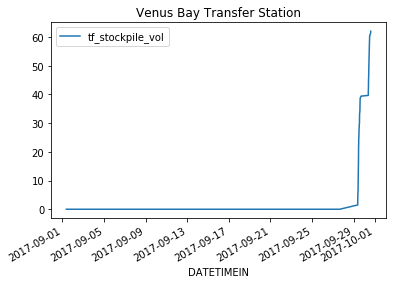

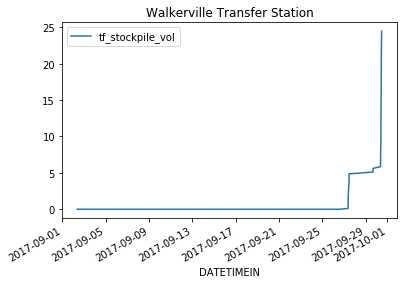

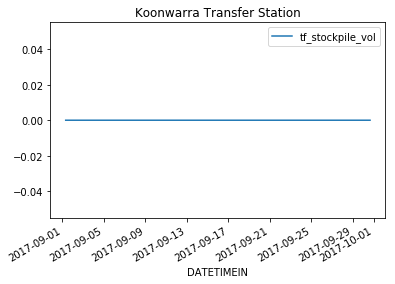

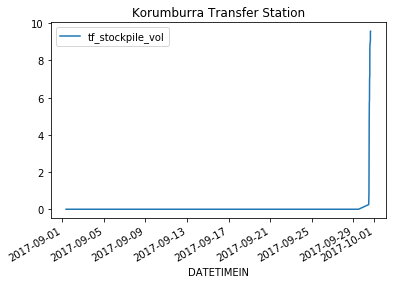

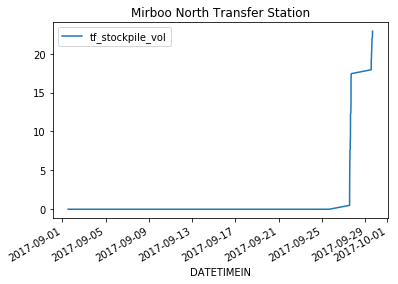

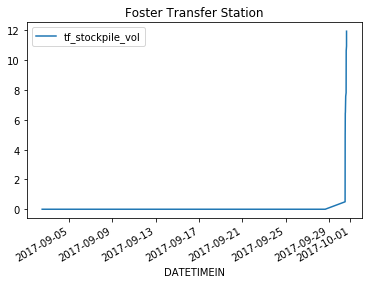

In [110]:
for facility in transaction['Facility NAME'].unique():
    transaction.loc[transaction['Facility NAME'] == facility].plot(x='DATETIMEIN', y='tf_stockpile_vol', title=facility)
    plt.savefig(facility + '_last_stockpile.png')

In [14]:
transaction.to_csv('transaction_data.csv', index=False, header=True)